# Project 4: Advanced Lane Lines
This notebook does the following
* Computes camera distortion matrix using set of calibration images
* Computes perspective warp and unwarp matrices
* Demonstrates stages of lane line detection pipeline
* Converts input video adding lane markers and curvature and position estimates

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

## Camera Calibration

In [492]:
def dist_coeffs(img_pattern, verbose=False):
    """Computes camera distortion matrix using a number of provided checkerboard calibration images"""
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    imgsize = None

    # Make a list of calibration images
    images = glob.glob(img_pattern) #'../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for img_idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if imgsize == None:
            imgsize = gray.shape[::-1]
        elif imgsize != gray.shape[::-1]:
          print("Image {} has wrong size {}".format(fname, gray.shape[::-1]))  

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if verbose:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
            #plt.subplots(121)
            axes[0].imshow(img)#fig.imshow(img)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            if verbose:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #plt.subplot(122)
                axes[1].imshow(img) #plt.imshow(img)
                #axes[int(img_idx/2), img_idx % 2].imshow(img)
                #cv2.waitKey(500)

    if verbose: plt.show()
    
    return cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
 

In [493]:
undist_err, mtx, dst_coefs, r_vecs, t_vecs = dist_coeffs('./camera_cal/calibration*.jpg')

Image ./camera_cal/calibration15.jpg has wrong size (1281, 721)
Image ./camera_cal/calibration7.jpg has wrong size (1281, 721)


In [491]:
def undistort(img):
    """Convenience function to undistort emages once camera distortion coeffieicents are known"""
    return cv2.undistort(img, mtx, dst_coefs)

Now that we have fast and convenient way of dealing with camera distortion, lets test it on calibration images.

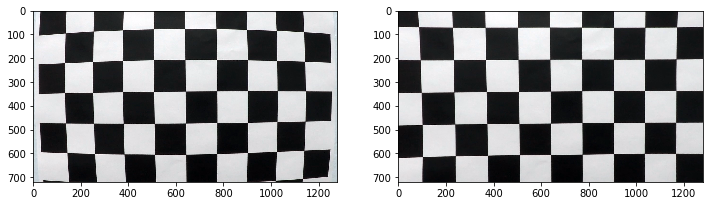

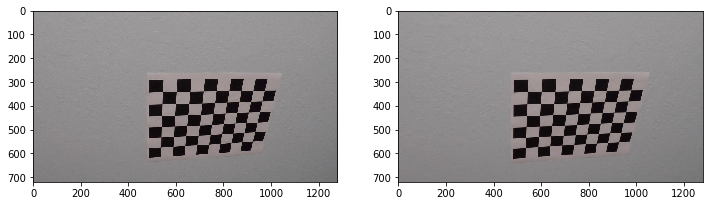

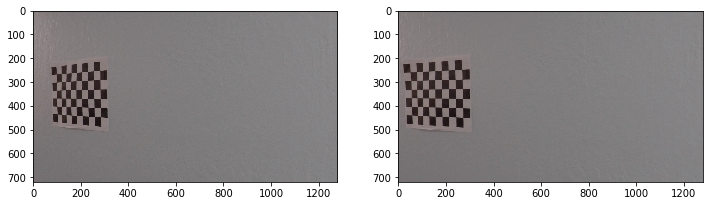

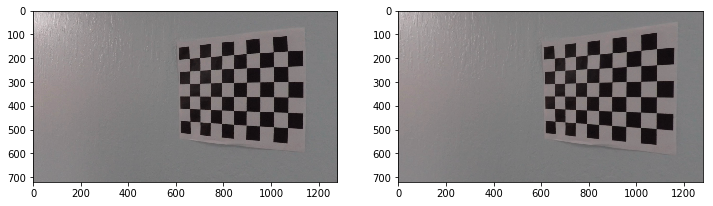

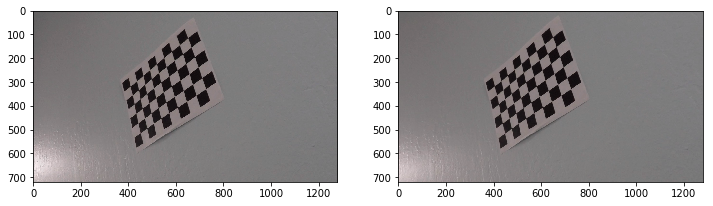

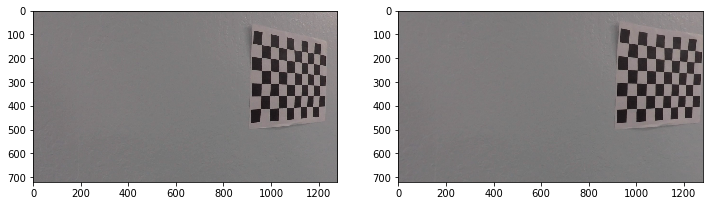

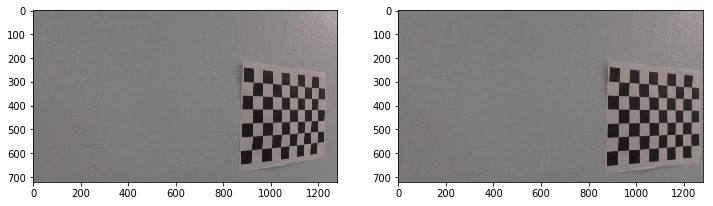

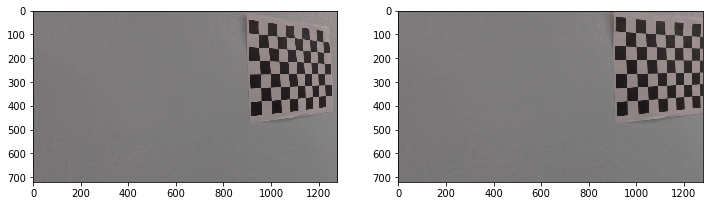

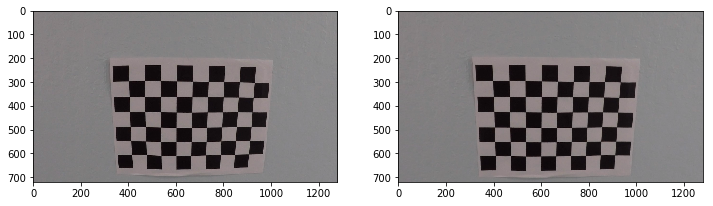

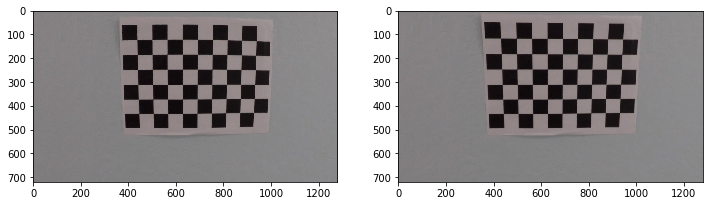

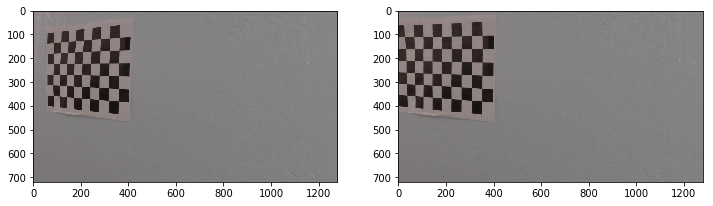

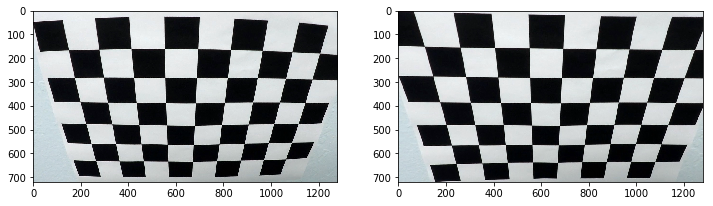

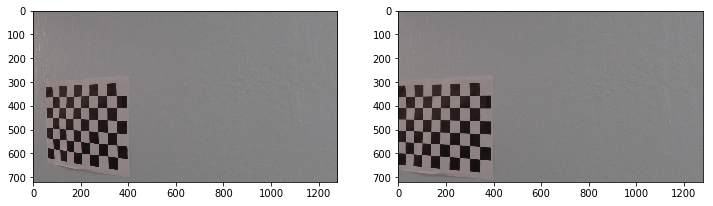

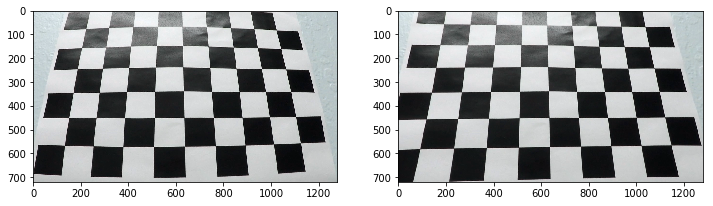

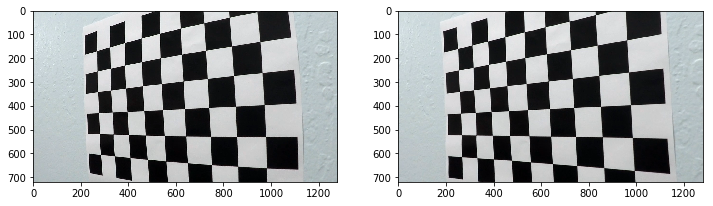

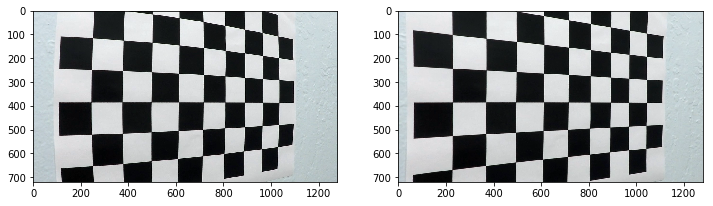

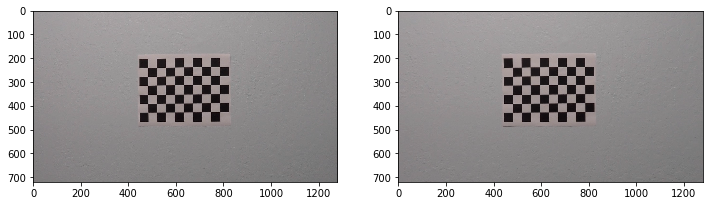

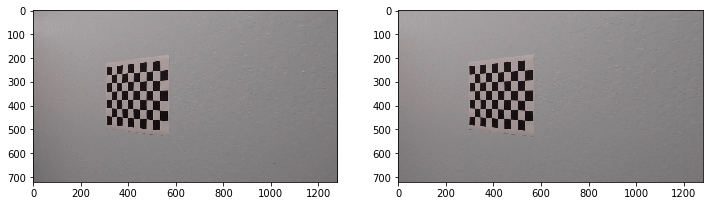

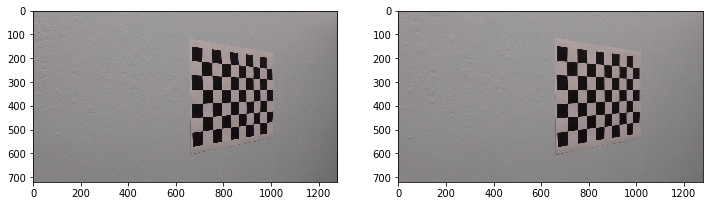

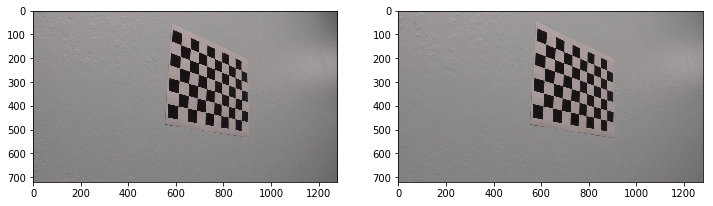

In [5]:
images = glob.glob('./camera_cal/calibration*.jpg')
for img_idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img) #cv2.undistort(img, mtx, dst_coefs)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
    axes[0].imshow(img)
    axes[1].imshow(dst)
plt.show()


Stunning. Now do the same thing with one of the actual road images.

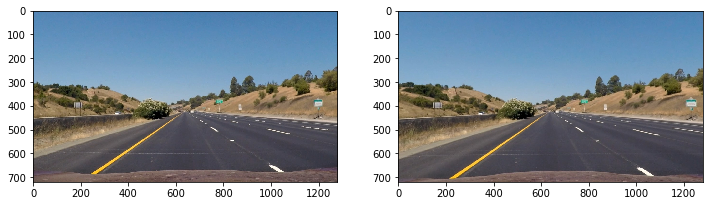

In [502]:
img = mpimg.imread("test_images/straight_lines1.jpg")
dst = undistort(img)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
axes[0].imshow(img)
axes[1].imshow(dst)
plt.show()

## Perspective Transformation
Use one sample image of the road to find 4 points that are known to form a rectangle on surface of the road in 3D space.

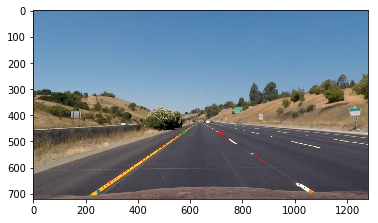

In [12]:
%matplotlib inline
img = mpimg.imread("test_images/straight_lines1.jpg")
img = undistort(img)
und_imgpoints = [[248, 690], [1058, 690], [573, 466], [711, 466]]
cv2.line(img, tuple(und_imgpoints[0]), tuple(und_imgpoints[2]), [255, 0, 0])
cv2.line(img, tuple(und_imgpoints[1]), tuple(und_imgpoints[3]), [255, 0, 0])
plt.imshow(img)
for p in und_imgpoints:
    plt.plot(p[0], p[1], '.')
und_imgpoints = np.float32(und_imgpoints)
plt.show()

In [166]:
unw_imgpoints = np.float32([[411, img.shape[0]-10], [884, img.shape[0]-10], [411, 160], [884, 160]])

Use selected points from original image and their expected positions on transformed image to calculate perspective transformation matrices.

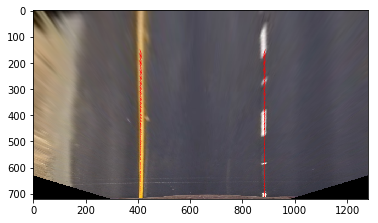

In [167]:
%matplotlib inline
warp_M = cv2.getPerspectiveTransform(und_imgpoints, unw_imgpoints)
warped = cv2.warpPerspective(img, warp_M, img.shape[-2::-1], flags=cv2.INTER_LINEAR)
plt.imshow(warped)
unwarp_M = cv2.getPerspectiveTransform(unw_imgpoints, und_imgpoints)

Perspective transformation looks good enough. Create a convenience function for it.

In [21]:
def warp_image(img, matrix):
    shape = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, matrix, shape, flags=cv2.INTER_LINEAR)

## Color and gradient transformations
Create functions for extracting different gradient thresholds and conversion to HLS colour space.

In [123]:

def get_sobel(img, orient, sobel_kernel):
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x = orient == 'x'
    y = orient == 'y'
    return cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)

def threshold_img(img, threshold):
    result = np.zeros_like(img)
    result[(img >= threshold[0]) & (img <= threshold[1])] = 1
    return result


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    sobel = get_sobel(img, orient, sobel_kernel) 
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    return sobel if thresh == None else threshold_img(sobel, thresh)

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 2) Take the gradient in x and y separately
    x_grad = get_sobel(image, 'x', sobel_kernel)
    y_grad = get_sobel(image, 'y', sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(x_grad) + np.square(y_grad))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    magnitude = np.uint8(magnitude * 255 / np.max(magnitude))
    return magnitude if mag_thresh == None else threshold_img(magnitude, mag_thresh)

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    x_grad = get_sobel(image, 'x', sobel_kernel)
    y_grad = get_sobel(image, 'y', sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(x_grad)
    abs_y = np.absolute(y_grad)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad)
    # 6) Return this mask as your binary_output image
    dir_binary[(grad > thresh[0]) & (grad < thresh[1])] = 1

    return dir_binary

def hls_select(image, threshold=None, channel=2):
    transformed = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,channel]
    if threshold == None:
        result = transformed
    else:
        result = np.zeros_like(transformed)
        result[(transformed > threshold[0]) & (transformed <= threshold[1])] = 1
    return result


Combine different gradients in a way that is supposedly most useful for detecting line lanes and test on sample image.

720
(720, 1280)


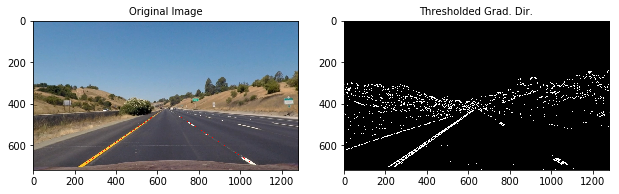

In [151]:
def gradient_combo(image, xthresh=(30,150), ythresh=(30,150), magthresh=(30,150)):
    ksize = 7 # Choose a larger odd number to smooth gradient measurements

    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xthresh)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=ythresh)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(.7, 1.3))

    #Try different combinations and see what you get.

    #For example, here is a selection for pixels where both the x and y gradients 
    #meet the threshold criteria, or the gradient magnitude and direction are both 
    #within their threshold values.

    combined = np.zeros_like(gradx)
    combined[((gradx == 1)| (grady == 1) | (mag_binary == 1)) & (dir_binary == 1)] = 1
    #combined = gradx, grady, mag_binary, dir_binary
    return combined #* 255

# Plot the result

grads = gradient_combo(img)
print(len(grads))
print(grads.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(grads, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=10)
#ax3.imshow(grads[-1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Check the combination of gradient thresholds and perspective warping.

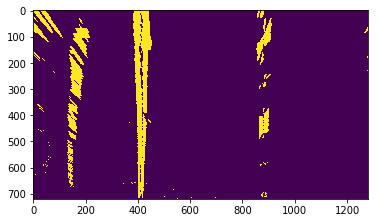

In [168]:
combo_warped = cv2.warpPerspective(gradient_combo(img), warp_M, img.shape[-2::-1], flags=cv2.INTER_LINEAR)
plt.imshow(combo_warped)

In [494]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

## Image Processing Pipeline
So this is the processing pipeline. Followed by short loop to try the pipeline on sample images.

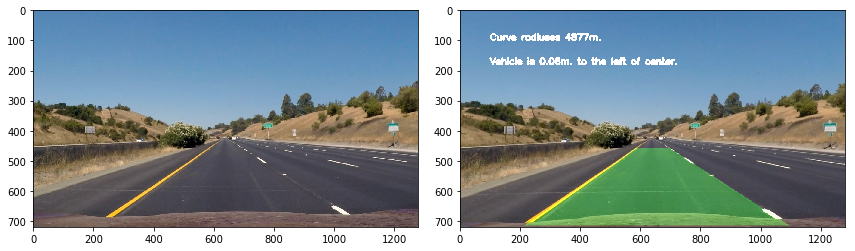

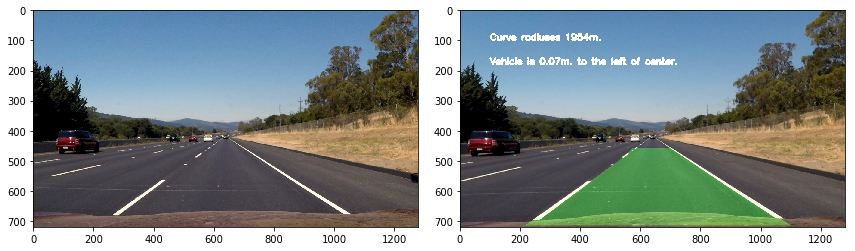

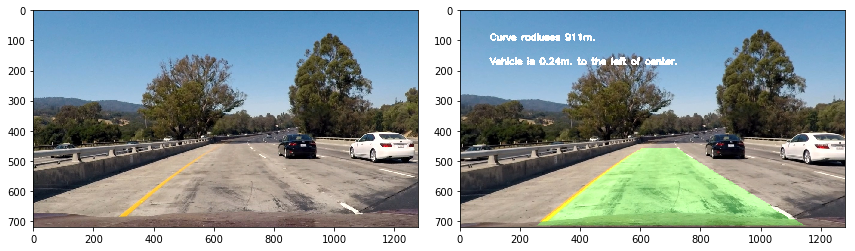

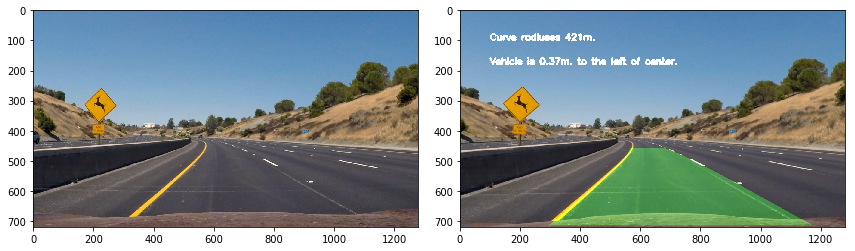

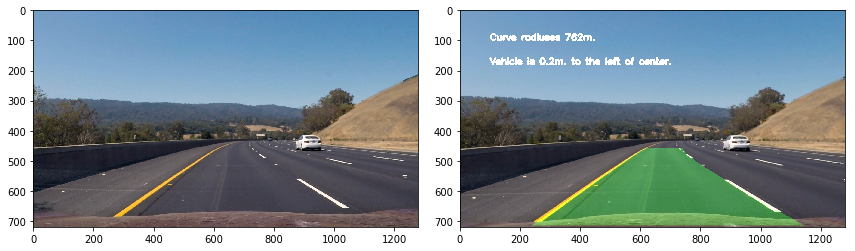

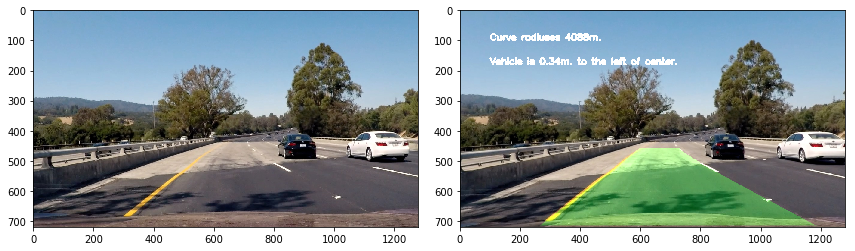

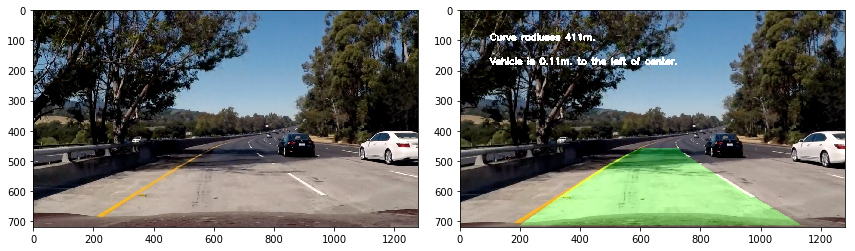

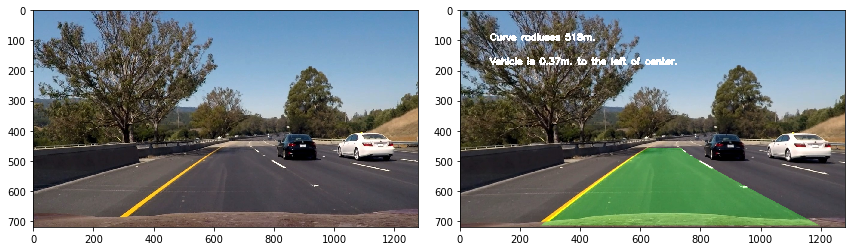

In [504]:
def process_image(image, diags=False):
    undist = undistort(image)
    hls = hls_select(undist)
    hls_grad = gradient_combo(hls, xthresh=(60, 120), ythresh=(75, 120), magthresh=(35, 250))

    result = warp_image(hls_grad, warp_M)
    result, left_x, right_x, curve_rad, offset = find_lanes(result, diags)
    if not diags:
        # If this is dignostic mode we are just returning rectified warped image for display
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        result = warp_image(result, unwarp_M)
        # Combine the result with the original image
        offset_dir = "right" if offset < 0 else "left"
        result = cv2.addWeighted(undist, 1, result, 0.3, 0)
        #Anotate result
        result = cv2.putText(result, "Curve radiuses {}m.".format(int(curve_rad)), 
                             (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
        result = cv2.putText(result, "Vehicle is {}m. to the {} of center.".format(round(abs(offset), 2), offset_dir),
                            (100, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
    
    return result


for tst_fname in glob.glob("test_images/*.jpg"):
    tst_image = plt.imread(tst_fname)
    fig, (orig, processed) = plt.subplots(ncols=2, figsize=(12, 9))
    fig.tight_layout()

    left_fit, right_fit = None, None
    left_line = Line()
    right_line = Line()
    
    orig.imshow(tst_image)
    grads = process_image(tst_image)
    processed.imshow(grads) 
plt.show()


This class holds data for basic smoothing of detected lane lines and curvature estimates between frames.

In [487]:
class Line():
    def __init__(self):
        # factor [0,1) by which to smooth out values
        self.smooth_factor = .75
        #smoothed x values of the fitted line
        self.bestx = None     
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
    
    def add_xfit(self, x):
        if self.bestx == None:
            self.bestx = x
        else:
            self.bestx = x + self.smooth_factor * (self.bestx - x)
        return self.bestx
    
    def add_radius(self, x):
        if self.radius_of_curvature == None:
            self.radius_of_curvature = x
        else:
            self.radius_of_curvature = x + self.smooth_factor * (self.radius_of_curvature - x)
        return self.radius_of_curvature


Load input clip and run few frames through pipeline in diagnostic mode, showing results.

[ -2.95785328e-04   3.80799831e-01   3.28411742e+02] [  2.01719351e-04  -5.20624863e-02   8.90258920e+02]


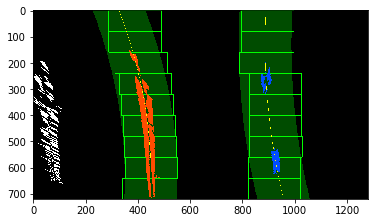

[ -2.31852693e-04   3.85601582e-01   2.97118146e+02] [ -1.49542993e-04   2.78299704e-01   8.06167017e+02]


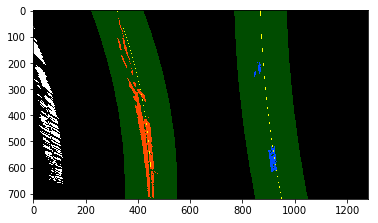

[ -2.95138123e-04   3.69159547e-01   3.18016241e+02] [ -3.97403525e-05   1.71807805e-01   8.09997552e+02]


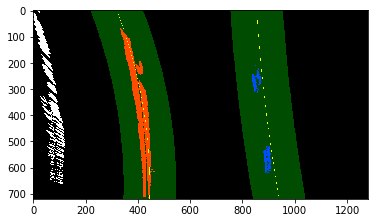

[ -2.45782144e-04   3.48382918e-01   3.28622747e+02] [  2.37446450e-05   1.23408221e-01   8.34225957e+02]


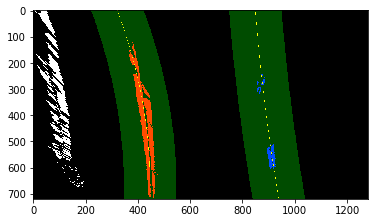

[ -2.78900648e-04   4.07010294e-01   2.86145382e+02] [ -1.59706708e-04   2.67878688e-01   8.17007726e+02]


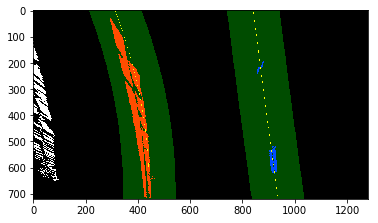

[ -2.90794061e-04   3.80622763e-01   2.88562931e+02] [ -2.55195686e-05   1.99565529e-01   7.74868978e+02]


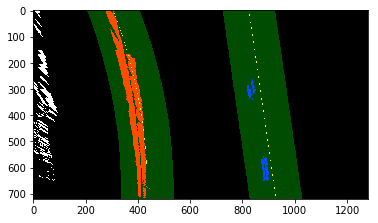

[ -8.80216794e-05   1.27408770e-01   3.88699331e+02] [  1.68895961e-04  -9.04908643e-02   9.00738496e+02]


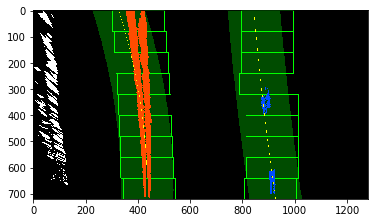

[ -8.80216794e-05   1.27408770e-01   3.88699331e+02] [  1.68895961e-04  -9.04908643e-02   9.00738496e+02]


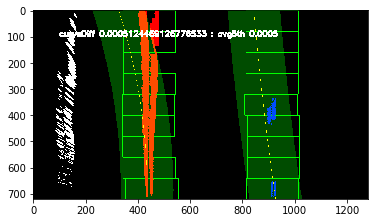

[ -1.73804489e-05   3.76974599e-02   4.17489576e+02] [  8.52768262e-05  -4.66631047e-02   9.12726989e+02]


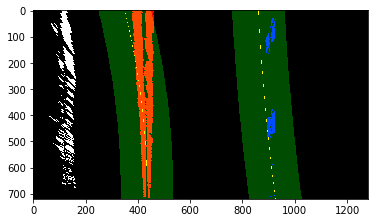

[  2.04256186e-05  -4.00769659e-02   4.27353046e+02] [  2.30173449e-04  -1.36040226e-01   9.00639016e+02]


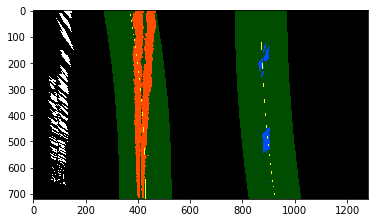

In [500]:
if not os.path.exists("test_videos_output"):
    os.mkdir('test_videos_output')
test_output = 'test_videos_output/test.mp4'
clip1 = VideoFileClip("project_video.mp4")
left_fit, right_fit = None, None
left_line, right_line = Line(), Line()
for i in range(0, 20, 2):
    frame1 = process_image(clip1.get_frame(i), True)
    print(left_fit, right_fit)
    plt.imshow(frame1)
    plt.show()

## Video processing
Routine to run the input clip through the pipeline and save the result.

In [505]:
left_fit, right_fit = None, None
left_line = Line()
right_line = Line()
print()
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/test.mp4
[MoviePy] Writing video test_videos_output/test.mp4


100%|█████████▉| 1260/1261 [05:43<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test.mp4 

CPU times: user 5min 14s, sys: 1min 17s, total: 6min 32s
Wall time: 5min 44s


In [501]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Support functions for lane detection
Function to detect lane lines when their position is not known.

In [434]:
def find_lane_start(binary_warped, out_img, nonzerox, nonzeroy, margin):    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if out_img != None:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds

    

Detect lane lines when  their positions are inferred from prior frame.

In [437]:
def find_line_next(binary_warped, nonzerox, nonzeroy, margin):
    global left_fit
    global right_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    return left_lane_inds, right_lane_inds


## Lane detection validation functions
Define couple of methods to check sanity of line fits. Lane lines are sane if they:
* Dont intersect and
* Dont cross the side boundaries of the image

For fits a and b, lines intersect if there is an x within or close outside image boundries such that 

`(a1-b1)*y**2 + (a2-b2)*y + (a3-b3) = 0`

Or after we do a = a - b

`a*y**2 + b*y + c = 0`

This solves to 
`y = (-b +/- sqrt(b**2 - 4c)) / 2a`

Also check if peak value of x is outside of image while corresponding y value is within. That is considered bad. Y value for peak x is:
`2*a*y + b = 0` 
which is equivalent to 
`y = -b/2/a`

In [496]:
def bottom_distance(left_fit, right_fit, image_shape):
    y_edge = image_shape[0]
    diff_fit = right_fit - left_fit
    return diff_fit[0] * y_edge**2 + diff_fit[1] * y_edge + diff_fit[2]

def clip_check(fit, image_shape):
    # check for clip at the top
    retVal = 0 <= fit[2] < image_shape[1]
    if retVal:
        # check for clip at the bottom
        x_bottom = fit[0] * (image_shape[0]-1)**2 + fit[1] * (image_shape[0]-1) + fit[2]
        retVal = 0 <= x_bottom < image_shape[1]
    if retVal:
        # check for clipped peak somewhere in-between
        y_peak = -fit[1]/2/fit[0]
        if 0 <= y_peak < image_shape[0]:
            x_peak = fit[0] * y_peak**2 + fit[1] * y_peak + fit[2]
            retVal = 0 <= x_peak < image_shape [1]
    return retVal
    
def fit_sanity(left_fit, right_fit, prior_distance, image_shape):
    retVal = None
    #if lines cross within or close outside image boundaries then its bad
    diff_fit = left_fit - right_fit
    ipart = (diff_fit[1])**2 - 4*(diff_fit[2])
    if ipart >= 0: #lines intersect somewhere
        y1 = (-(diff_fit[1]) + math.sqrt(ipart)) / (2 * diff_fit[0])
        y2 = (-(diff_fit[1]) - math.sqrt(ipart)) / (2 * diff_fit[0])
        if image_shape[0] > y1 > -image_shape[0]/2 or image_shape[0] > y2 > -image_shape[0]:
            #retVal = False
            retVal = "Intersect at {} and {}".format(y1, y2)
            return retVal
    #left and right curvature are within 10% of their average
    curveDiff = abs(left_fit[0] - right_fit[0])
    curveAvg_5th = .0005 #abs((left_fit[0] + right_fit[0]) / 2)
    if curveDiff > curveAvg_5th:
        retVal = "curveDiff {} : avg5th {}".format(curveDiff, curveAvg_5th)
        return retVal
    # ... and angles are within 15 degrees
    angleDiff = (abs(math.atan(left_fit[1]) - math.atan(right_fit[1])))
    if angleDiff > np.pi / 12:
        retVal = "angleDiff {}".format(angleDiff)
        return retVal
    # ...and distance is 
    distance = bottom_distance(left_fit, right_fit, image_shape)
    if abs(prior_distance - distance) > prior_distance / 8:
        retVal = "prior distance {} : distance {}".format(prior_distance, distance)
        return retVal
    if not clip_check(left_fit, image_shape): return "Left curve clips"
    if not clip_check(right_fit, image_shape): return "Right curve clips"
    return retVal

## Flatland controller
All the processing that is done on 2D projection of road surface is controlled by find_lanes function below. This entails:
* Finding lanes
* Sanity check of found lanes
* Drawing a bounding rectangle around found lanes
* Calculation of line curvature radius and vehicle position

In [341]:
def fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
        # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit_candidate, right_fit_candidate = None, None
    if len(lefty) > 0 and len(leftx) > 0 : 
        left_fit_candidate = np.polyfit(lefty, leftx, 2)
    if len(righty) > 0 and len(rightx) > 0: 
        right_fit_candidate = np.polyfit(righty, rightx, 2)
        
    return left_fit_candidate, right_fit_candidate


In [503]:
def find_lanes(binary_warped, render=True):
    global left_fit
    global right_fit
    global left_line
    global right_line
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 if render else None

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    start_search = True
    if left_fit == None or right_fit == None: #then we have to search for lane positions
        left_lane_inds, right_lane_inds = find_lane_start(binary_warped, out_img,
                                                          nonzerox, nonzeroy, margin)
    else: #we assume line positions from prior fit
        left_lane_inds, right_lane_inds = find_line_next(binary_warped, 
                                                         nonzerox, nonzeroy, margin)
        start_search = False
        left_fit_candidate, right_fit_candidate = None, None
        
    left_fit_candidate, right_fit_candidate = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    fit_sane = None
    
    if (not start_search and left_fit_candidate != None and right_fit_candidate != None):
        #check fit sanity if position is inferred from prior frame
        current_dist = bottom_distance(left_fit, right_fit, binary_warped.shape)
        fit_sane = fit_sanity(left_fit_candidate, right_fit_candidate, 
                               current_dist, binary_warped.shape)
        if fit_sane != None: #if that fails fit again from scratch 
            left_lane_inds, right_lane_inds = find_lane_start(binary_warped, out_img,
                                                          nonzerox, nonzeroy, margin)
            left_fit_candidate, right_fit_candidate = fit_lines(nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
            #check this result too in case we are dealing with really bad frame
            fit_sane = fit_sanity(left_fit_candidate, right_fit_candidate, 
                                  current_dist, binary_warped.shape)
                                    
    if fit_sane == None: # if fit is accepted, use it from this point on
        if left_fit_candidate != None: left_fit = left_fit_candidate
        if right_fit_candidate != None: right_fit = right_fit_candidate        
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if fit_sane == None: #blend new fitted line with old one
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_fitx = left_line.add_xfit(left_fitx)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_fitx = right_line.add_xfit(right_fitx)
    else: #or just use old one since new is no good
        left_fitx = left_line.bestx
        right_fitx = right_line.bestx

    if render:
        window_img = np.zeros_like(out_img)

        # Repaint detected lane lines
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw green fitted lines
        out_img[ploty.astype(np.uint16), left_fitx.astype(np.uint16)] = [255, 255, 0]
        out_img[ploty.astype(np.uint16), right_fitx.astype(np.uint16)] = [255, 255, 0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        if fit_sane != None:
    #        print(fit_sane) add diagnostic message
            out_img = cv2.putText(out_img, fit_sane, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 5)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    else:
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        result = color_warp
        
    # Compute curvature radius
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = result.shape[0]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    if fit_sane == None: #Blend new radius with old result
        left_curverad = left_line.add_radius(left_curverad)
        right_curverad = right_line.add_radius(right_curverad)
    else: # Or just use new result if we dont trust the new one.
        left_curverad = left_line.radius_of_curvature
        right_curverad = right_line.radius_of_curvature
    
    # Calculate camera offset from middle of the lane
    left_edge = left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]
    right_edge = right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2]
    center_offset = (left_edge - (result.shape[1] - right_edge)) * xm_per_pix / 2

    return result, left_fitx, right_fitx, (left_curverad + right_curverad) / 2, center_offset

